In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, average_precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_val_score, train_test_split

import IPython
os.environ['NUMBA_CACHE_DIR'] = IPython.paths.get_ipython_cache_dir()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get the user's home directory (e.g., 'C:\Users\user')
DATA_DIR = r"C:\Users\ferit\MLPC2025_classification"
metadata_dir = os.path.join(DATA_DIR, 'metadata.csv')
features_dir = os.path.join(DATA_DIR, 'audio_features')
labels_dir = os.path.join(DATA_DIR, 'labels')

#### Load Metadata

In [3]:
# Load Metadata & Training Files
metadata = pd.read_csv(metadata_dir)
train_files = metadata.sample(len(metadata), random_state=42)["filename"].unique()

#### Load categories

In [4]:
# Select a random audio file and its annotations
np.random.seed(1)
sample_file = np.random.choice(metadata['filename'].tolist())

# Load corresponding label file
label_filename = sample_file.replace('.mp3', '_labels.npz')
label_path = os.path.join(DATA_DIR, 'labels', label_filename)
labels = np.load(label_path)

# Load categories
categories = list(labels.keys())
print("Names of Label Classes: \n", categories)

Names of Label Classes: 
 ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow', 'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip', 'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh', 'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill', 'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat', 'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck', 'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']


#### Aggregate Labels

In [5]:
# Aggregate Labels
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

### Split Train Data

#### Read Files

In [6]:
# Read files and split train data
import itertools
def read_files(file_names, num_to_read=(len(train_files))):
    X_train = []
    Y_train = {}
    for c in categories:
        Y_train[c] = []
    for f in file_names[:num_to_read]:
        if not os.path.exists(os.path.join(features_dir , f.split('.')[0] + '.npz')):
            continue
        features = np.load(os.path.join(features_dir , f.split('.')[0] + '.npz'))["embeddings"]
        X_train.append(features)
        y = np.load(os.path.join(labels_dir , f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y)))
    X_train = np.concatenate(X_train)
    return X_train, Y_train

#### Split data without data leakage

In [7]:
# Split data without data leakage
train_files, test_files = train_test_split(metadata["filename"].unique(), test_size=0.2, random_state=42)
#So final split: 80% train, 20% test

# Print number of train and test files
print(f"{'Number of train files: ':<30}{len(train_files)}")
print(f"{'Number of test files: ':<30}{len(test_files)}")

Number of train files:        6584
Number of test files:         1646


#### Load train & test (subset) data

In [8]:
# High computational effort!!!

In [9]:
# Load train & test data
X_train_raw, Y_train = read_files(train_files, 800)
X_test_raw, Y_test = read_files(test_files, 200)

# print raw feature tensor shapes
print("Train shapes (raw):", X_train_raw.shape, len(Y_train))
print("Test shapes  (raw):", X_test_raw.shape, len(Y_test))

Train shapes (raw): (149303, 768) 58
Test shapes  (raw): (37022, 768) 58


### Apply Feature Normalization & PCA dimensionality reduction (with 95% explained variance)

#### Feature Tensor Scaler

In [10]:
from sklearn.preprocessing import StandardScaler

# Compute scaling parameters ONLY on training data
scaler = StandardScaler().fit(X_train_raw)

#### Scale & Normalize Feature Tensor

In [11]:
# Scale Train and Test Feature Tensor
X_train_scaled = scaler.transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# print scaled feature tensor shapes
print("Train shapes (scaled):", X_train_scaled.shape, len(Y_train))
print("Test shapes  (scaled):", X_test_scaled.shape, len(Y_test))

Train shapes (scaled): (149303, 768) 58
Test shapes  (scaled): (37022, 768) 58


#### Dimensionality reduction for Feature Tensor with PCA

In [12]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction with keeping 95% of the variance
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_scaled) # fit and transform train feature tensor
X_test = pca.transform(X_test_scaled)       # transform test feature tensor

# print reduced feature tensor shapes
print("Train shapes (reduced):", X_train.shape, len(Y_train))
print("Test shapes  (reduced):", X_test.shape, len(Y_test))

Train shapes (reduced): (149303, 184) 58
Test shapes  (reduced): (37022, 184) 58


### Training Experiments

#### Split Data 'Speech'

In [13]:
# Split data 'Speech'
speech_X_train, speech_Y_train = X_train, np.array(Y_train['Speech'])
speech_X_test, speech_Y_test = X_test, np.array(Y_test['Speech'])

#### Confusion Matrix for Classifier

In [14]:
def classifier_confusion_matrix(Y_train, Y_train_pred, Y_test, Y_test_pred):
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    # Train confusion matrix
    cm_train = confusion_matrix(Y_train, Y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_train.plot(cmap='Blues', ax=axes[0], colorbar=False)
    axes[0].set_title("Confusion Matrix - Train Set")
    
    # Test confusion matrix
    cm_test = confusion_matrix(Y_test, Y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_test.plot(cmap='Blues', ax=axes[1], colorbar=False)
    axes[1].set_title("Confusion Matrix - Test Set")
    
    plt.tight_layout()

#### Performance Metrics for Classifier

In [15]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    average_precision_score, recall_score, f1_score, roc_auc_score
)

def performance_metrics(y_test, y_test_pred):
    accuracy      = accuracy_score(y_test, y_test_pred)
    precision     = precision_score(y_test, y_test_pred, zero_division=0)
    recall        = recall_score(y_test, y_test_pred)
    f1            = f1_score(y_test, y_test_pred)
    roc_auc       = roc_auc_score(y_test, y_test_pred)
    pr_auc        = average_precision_score(y_test, y_test_pred)
    weighted_acc  = balanced_accuracy_score(y_test, y_test_pred)

    print(f"Accuracy:         {accuracy:.3f}")
    print(f"Weighted Accuracy:{weighted_acc:.3f}")
    print(f"Precision:        {precision:.3f}")
    print(f"Recall:           {recall:.3f}")
    print(f"F1 Score:         {f1:.3f}")
    print(f"ROC AUC:          {roc_auc:.3f}")
    print(f"PR AUC:           {pr_auc:.3f}")
    
    return {
        "accuracy": accuracy,
        "weighted_accuracy": weighted_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

#### Baseline Classifier

In [16]:
# Baseline Classifier
class Baseline_classifier():

    def __init__(self):
        self.majority_class = None

    def fit(self, x_train, y_train):
        '''x_train is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        y_train is a list of binary labels in the shape Nx1
        '''
        
        self.majority_class = 1 if sum(y_train) > len(y_train) / 2 else 0

    def predict(self, x):
        '''x is a numpy array of features with shape NxD, where N is the number of datapoints and D the feature dimension
        The function should return the predicted binary labels as a numpy array of shape Nx1
        '''
        predictions = np.zeros(x.shape[0]) + self.majority_class
        return predictions

#### Train baseline model

In [17]:
# Train baseline model
baseline = Baseline_classifier()
baseline.fit(speech_X_train, speech_Y_train) # predicts the majority class (non-speech) for all samples

# Predictions
Y_train_pred = baseline.predict(X_train)
Y_test_pred = baseline.predict(X_test)

#### Baseline Confusion Matrix

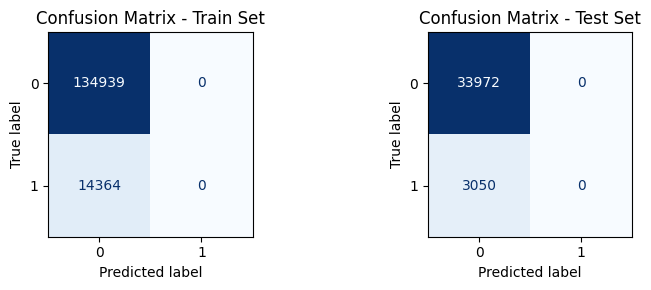

In [18]:
# Baseline Confusion Matrix
classifier_confusion_matrix(speech_Y_train, Y_train_pred, speech_Y_test, Y_test_pred)
    
plt.savefig('Confusion_Matrix_Baseline_Classifier_Subset')
plt.show()

#### Baseline Performance Metrics

In [19]:
# Baseline Performance Metrics 
print("Performance Metrics – Baseline Classifier")
print("=" * 60)
base_perf = performance_metrics(speech_Y_test, Y_test_pred)

Performance Metrics – Baseline Classifier
Accuracy:         0.918
Weighted Accuracy:0.500
Precision:        0.000
Recall:           0.000
F1 Score:         0.000
ROC AUC:          0.500
PR AUC:           0.082


### kNN Classifier

In [20]:
# High computational effort!!!

In [21]:
# kNN Classifier
k=1
knn = KNeighborsClassifier(n_neighbors=k)

# Fit train data and predict labels
knn.fit(speech_X_train, speech_Y_train)

Y_train_pred = knn.predict(speech_X_train)
Y_test_pred = knn.predict(speech_X_test)

#### kNN Confusion Matrix

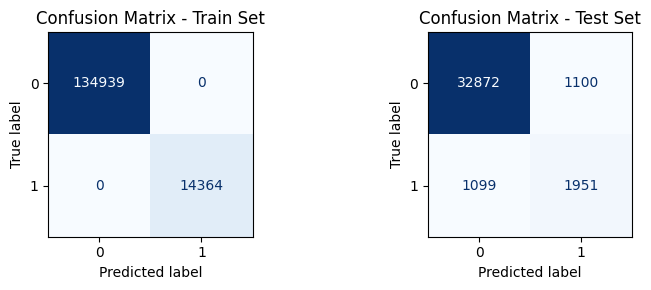

In [22]:
# kNN Confusion Matrix
classifier_confusion_matrix(speech_Y_train, Y_train_pred, speech_Y_test, Y_test_pred)

plt.savefig(f'Confusion_Matrix_kNN_Classifier_Subset_k{k}')
plt.show()

#### kNN Performance Metrics

In [23]:
# kNN Performance Metrics 
print("Performance Metrics – kNN Classifier")
print("=" * 60)
kNN_perf = performance_metrics(speech_Y_test, Y_test_pred)

Performance Metrics – kNN Classifier
Accuracy:         0.941
Weighted Accuracy:0.804
Precision:        0.639
Recall:           0.640
F1 Score:         0.640
ROC AUC:          0.804
PR AUC:           0.439


#### Random Forest Classifier

In [24]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=3, random_state=42)

# Fit train data and predict labels
rf.fit(X_train, speech_Y_train)

Y_train_pred = rf.predict(X_train)
Y_test_pred = rf.predict(X_test)

#### Random Forest Confusion Matrix

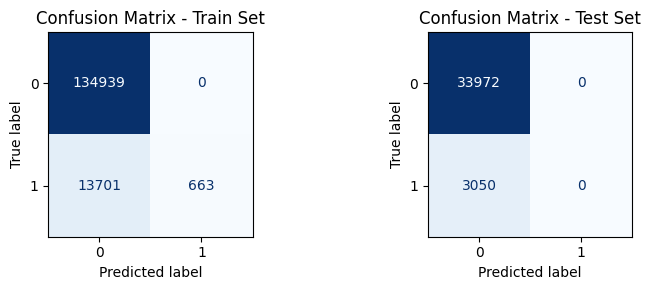

In [25]:
# Random Forest Confusion Matrix
classifier_confusion_matrix(speech_Y_train, Y_train_pred, speech_Y_test, Y_test_pred)

plt.savefig(f'Confusion_Matrix_RF_Classifier_Subset')
plt.show()

#### Random Forest Performance Metrics

In [26]:
# Random Forest Performance Metrics
print("Performance Metrics – Random Forest Classifier")
print("=" * 60)
rf_perf = performance_metrics(speech_Y_test, Y_test_pred)

Performance Metrics – Random Forest Classifier
Accuracy:         0.918
Weighted Accuracy:0.500
Precision:        0.000
Recall:           0.000
F1 Score:         0.000
ROC AUC:          0.500
PR AUC:           0.082


#### XGBoost Classifier

In [27]:
# XGBoost Classifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42)

# Fit train data and predict labels
xgb.fit(X_train, speech_Y_train)

Y_train_pred = xgb.predict(X_train)
Y_test_pred = xgb.predict(X_test)

#### XGBoost Confusion Matrix

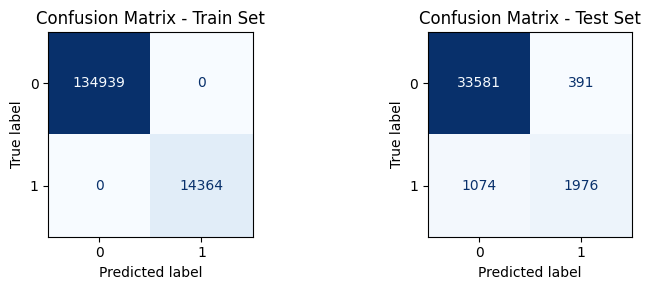

In [28]:
# XGBoost Confusion Matrix
classifier_confusion_matrix(speech_Y_train, Y_train_pred, speech_Y_test, Y_test_pred)

plt.savefig(f'Confusion_Matrix_XGB_Classifier_Subset')
plt.show()

#### XGBoost Performance Metrics

In [29]:
# XGBoost Performance Metrics
print("Performance Metrics – XGBoost Classifier")
print("=" * 60)
xgb_perf = performance_metrics(speech_Y_test, Y_test_pred)

Performance Metrics – XGBoost Classifier
Accuracy:         0.960
Weighted Accuracy:0.818
Precision:        0.835
Recall:           0.648
F1 Score:         0.730
ROC AUC:          0.818
PR AUC:           0.570


#### CUDA availability check

In [30]:
import torch
print("CUDA version:",torch.version.cuda)  # Should show your CUDA version

# CUDA availability check
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")

CUDA version: 12.8
Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### Neural Network Classifier

In [31]:
# Neural Network Classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(speech_Y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(speech_Y_test)

# Create datasets and dataloaders
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

In [33]:
# Initialize model, loss and optimizer
model = SimpleNN(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
    
    # Print training progress
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation function
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.squeeze().numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

# Get predictions
train_labels, train_preds = evaluate_model(model, train_loader)
test_labels, test_preds = evaluate_model(model, test_loader)

Epoch [2/10], Loss: 0.0015
Epoch [4/10], Loss: 0.0022
Epoch [6/10], Loss: 0.0029
Epoch [8/10], Loss: 0.0060
Epoch [10/10], Loss: 0.0009


#### SimpleNN Confusion Matrix

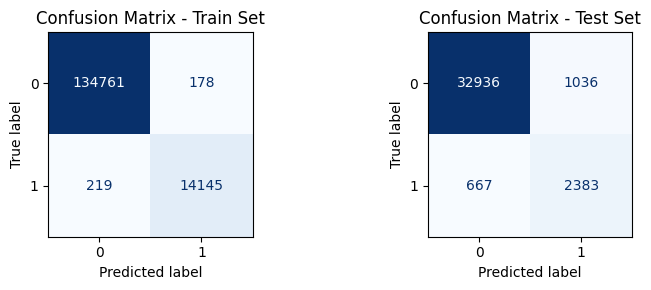

In [35]:
classifier_confusion_matrix(train_labels, train_preds, test_labels, test_preds)
plt.savefig('Confusion_Matrix_SimpleNN_Classifier')
plt.show()

#### SimpleNN Performance Metrics

In [36]:
# SimpleNN Performance Metrics
print("\nSimpleNN Performance:")
print("=" * 60)
nn_perf = performance_metrics(test_labels, test_preds)


SimpleNN Performance:
Accuracy:         0.954
Weighted Accuracy:0.875
Precision:        0.697
Recall:           0.781
F1 Score:         0.737
ROC AUC:          0.875
PR AUC:           0.563
